In [1]:
# Loading libraries
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the data
try:
    df_all = pd.read_csv('rugby.csv')
except:
    df_all = pd.read_csv(pm.get_data('rugby.csv'), index_col=0)

In [3]:
df = df_all[['home_team', 'away_team', 'home_score', 'away_score']]

teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

In [4]:
# building the model
with pm.Model() as model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Flat('intercept')
    
    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)
 
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])
    
    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 3 chains, 0 divergences: 100%|██████████████████████████████████████| 18000/18000 [00:29<00:00, 601.65draws/s]
The acceptance probability does not match the target. It is 0.6529157281517503, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


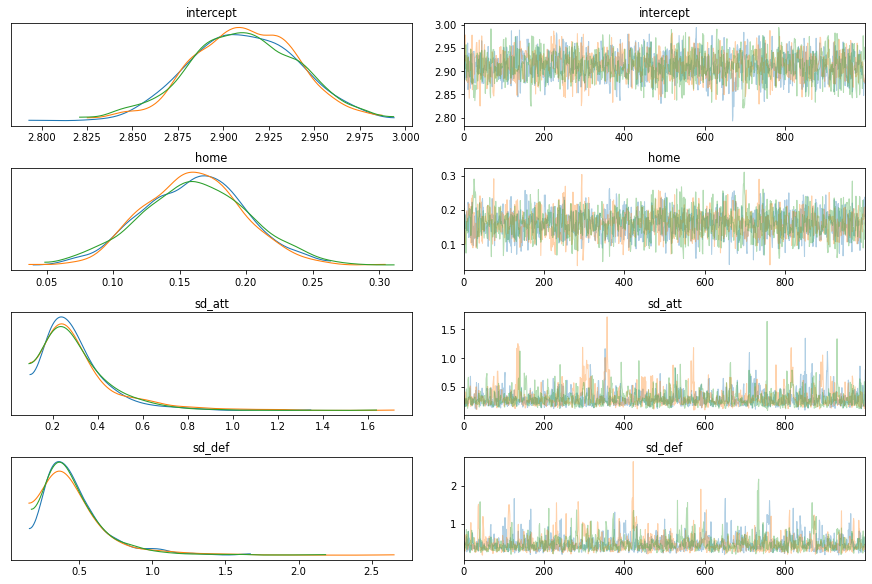

In [5]:
with model:
    trace = pm.sample(1000, tune=5000, cores=3)

az.plot_trace(trace, var_names=['intercept', 'home', 'sd_att', 'sd_def']);

In [6]:
# Generating the arviz data object
data = az.from_pymc3(
    trace=trace,
    model=model
)

data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [7]:
# Storing the model to .nc format
data.to_netcdf('rugby.nc')

'rugby.nc'